# 📒 Notebook: 03_final_config_evaluation.ipynb  
# 🔍 Purpose: Evaluate the stability of the selected MLP configuration using multiple random seeds.  
# 🔧 Workflow includes training, metrics logging, and saving the best-performing model.

---

## 🧠 Overview

This notebook loads the best saved MLP configuration (`config_XXX.json`), evaluates it over multiple runs with different random seeds, and analyzes the stability of the results.

---

## 🗂️ Structure

### 1. **Load Configuration**
- Load `config_XXX.json` from the specified folder.
- Convert activation function string to actual PyTorch object.
- Generate a unique `arch_label` for result naming.

### 2. **Train MLP Model**
- Run training for each seed using the loaded configuration.
- Use hold-out validation (80/20 split) with early stopping.
- Evaluate using R², MAE, and MSE metrics.
- Store results and best model weights.

### 3. **Save Outputs**
- Save the best weights as `.pt` file.
- Save detailed metrics for each run as `.csv`.
- Save best run metrics as `.json`.

### 4. **Analyze Stability**
- Calculate mean and std for all metrics across seeds.
- Save aggregated stability metrics as `.json`.
- Plot:
  - Line chart of R² across runs
  - Boxplot of R² distribution
  - Histogram of MAE

---

## 💾 Output Artifacts
- `best_model_weights_<arch_label>.pt`
- `results_<arch_label>.csv`
- `metrics_best_<arch_label>.json`
- `stability_<arch_label>.json`
- `stability_plot_<arch_label>.png`

---

## 🏁 Goal
To ensure the selected configuration performs consistently across random seeds and is robust enough for deployment or further testing.


In [15]:
# 📦 Imports and Configuration

import os
import json
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [16]:
# 📁 src/data/load_dataset.py
# ➤ Function for loading the dataset from CSV

def load_dataset():
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

In [17]:
# 📁 src/tuning/setup_paths.py
# ➤ Paths for hyperparameter search: tuning runs, logs, results

#DATA_PATH = "/kaggle/input/wind-pressure-prediction-2025/windloading_train.csv"
#SAVE_ROOT = "/kaggle/working"

DATA_PATH = "/mnt/d/projects/wind_pressure_prediction_2025/data/processed/windloading_train.csv"
SAVE_ROOT = "/mnt/d/projects/wind_pressure_prediction_2025/final_models/config_001"

In [18]:
# 📁 src/models/mlp_model.py
# ➤ Definition of the MLP architecture with customizable activation function

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_fn):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [19]:
# 📁 src/tuning/load_config.py
# ➤ Load best configuration from saved JSON, convert activation string to function,
# ➤ build readable architecture label for logging and saving results

# 📌 Path to the config directory and file
config_path = glob.glob(os.path.join(SAVE_ROOT, "config*.json"))[0]

# 🔁 Mapping string from config.json to actual PyTorch activation function
activation_map = {
    "ReLU": torch.nn.ReLU,
    "Tanh": torch.nn.Tanh,
    "LeakyReLU": torch.nn.LeakyReLU
}

# 📦 Load and decode configuration
with open(config_path, "r") as f:
    config = json.load(f)

# 🔧 Convert activation function string to callable object
config["activation_fn"] = activation_map[config["activation_fn"]]

# 🏷 Extract config name from path
config_name = os.path.basename(os.path.dirname(config_path))  # → 'config_001'

# 🧠 Build architecture label
arch_label = (
    f"mlp_{config['hidden_dim']}h_"
    f"{config['lr']:.0e}lr_"
    f"{config['batch_size']}bs_"
    f"{config['epochs']}ep_"
    f"{config['activation_fn'].__name__}_"
    f"{config['optimizer_name']}"
)

print("✅ Loaded config:")
print(config)
print(f"📂 SAVE_ROOT: {SAVE_ROOT}")
print(f"📁 arch_label: {arch_label}")

✅ Loaded config:
{'input_dim': 5, 'hidden_dim': 64, 'output_dim': 1, 'lr': 0.007, 'epochs': 100, 'batch_size': 32, 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'optimizer_name': 'Adam', 'features': ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'], 'targets': ['Mean']}
📂 SAVE_ROOT: /mnt/d/projects/wind_pressure_prediction_2025/final_models/config_001
📁 arch_label: mlp_64h_7e-03lr_32bs_100ep_Tanh_Adam


In [20]:
# 📁 src/metrics/regression_metrics.py
# ➞ Function to compute regression metrics: MSE, MAE, R²

def evaluate_regression(y_true, y_pred):
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()

    # 🔍 Remove NaNs before computing metrics
    mask = ~np.isnan(y_true_np) & ~np.isnan(y_pred_np)
    y_true_np = y_true_np[mask]
    y_pred_np = y_pred_np[mask]

    if len(y_true_np) == 0 or len(y_pred_np) == 0:
        raise ValueError("No valid data points after removing NaNs.")

    mse = mean_squared_error(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    return {"MSE": mse, "MAE": mae, "R2": r2}


In [21]:
# 📁 src/tuning/train_mlp_function.py
# ➤ Train MLP model with specified hyperparameters and seed
# ➤ Includes data loading, train-test split, early stopping, and evaluation
# ➤ Returns run_id and evaluation metrics on hold-out set


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mlp(hidden_dim, lr, batch_size, epochs, output_dim=1, activation_fn=nn.ReLU, optimizer_name="Adam", seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

    # ----------------------------
    # Load dataset
    # ----------------------------
    df = load_dataset()
    X = df[['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang']]
    y = df[['Mean']]
    input_dim = X.shape[1]

    # 🔀 Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # 📊 Plot distribution of target in train and test
    plt.figure(figsize=(8, 4))
    plt.hist(y_train.values, bins=30, alpha=0.6, label="Train", color='blue')
    plt.hist(y_test.values, bins=30, alpha=0.6, label="Test", color='orange')
    plt.title(f"🎯 Target Distribution (seed={seed})")
    plt.xlabel("Mean target value")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 🧪 Проверка на пересечение train и test
    intersection = set(X_train.index).intersection(set(X_test.index))
    if intersection:
        print(f"⚠️ Warning: Found {len(intersection)} overlapping samples in train and test!")
    else:
        print("✅ Train and test are properly separated (no overlap).")



    # Convert to tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

    # ----------------------------
    # Model creation
    # ----------------------------
    model = MLP(input_dim, hidden_dim, output_dim, activation_fn=activation_fn).to(device)
    criterion = nn.MSELoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    early_stopping_patience = 100
    best_loss = float("inf")
    patience_counter = 0
    train_loss_history = []

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        train_loss_history.append(current_loss)

        log_interval = max(1, epochs // 10)
        if (epoch + 1) % log_interval == 0 or (epoch + 1) == epochs:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {current_loss:.4f}")

        # Early Stopping
        if current_loss < best_loss:
            best_loss = current_loss
            patience_counter = 0
            best_weights = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

    run_id = f"run_seed_{seed}"

    model.load_state_dict(best_weights)
    weights_registry[run_id] = best_weights


    # ----------------------------
    # Evaluate
    # ----------------------------
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        metrics = evaluate_regression(y_test_tensor, y_pred)

    print(f"\n📊 Metrics:\n{metrics}")
    return run_id, metrics



🔁 Run 1 / 20 (seed = 0)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


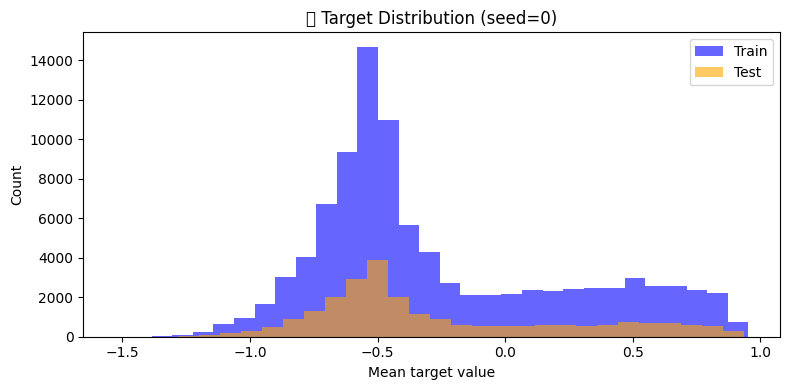

✅ Train and test are properly separated (no overlap).


Epochs:  15%|█▌        | 15/100 [00:00<00:02, 32.04it/s]

Epoch [10/100], Loss: 0.2582


Epochs:  23%|██▎       | 23/100 [00:00<00:02, 30.21it/s]

Epoch [20/100], Loss: 0.2200


Epochs:  35%|███▌      | 35/100 [00:01<00:02, 30.61it/s]

Epoch [30/100], Loss: 0.2043


Epochs:  43%|████▎     | 43/100 [00:01<00:01, 30.13it/s]

Epoch [40/100], Loss: 0.1840


Epochs:  55%|█████▌    | 55/100 [00:01<00:01, 31.54it/s]

Epoch [50/100], Loss: 0.1562


Epochs:  63%|██████▎   | 63/100 [00:02<00:01, 32.29it/s]

Epoch [60/100], Loss: 0.1159


Epochs:  75%|███████▌  | 75/100 [00:02<00:00, 30.98it/s]

Epoch [70/100], Loss: 0.0915


Epochs:  83%|████████▎ | 83/100 [00:02<00:00, 30.98it/s]

Epoch [80/100], Loss: 0.0870


Epochs:  95%|█████████▌| 95/100 [00:03<00:00, 31.66it/s]

Epoch [90/100], Loss: 0.0836


Epochs: 100%|██████████| 100/100 [00:03<00:00, 31.07it/s]


Epoch [100/100], Loss: 0.0816

📊 Metrics:
{'MSE': 0.08085065335035324, 'MAE': 0.19998522102832794, 'R2': 0.6701353788375854}

🔁 Run 2 / 20 (seed = 1)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


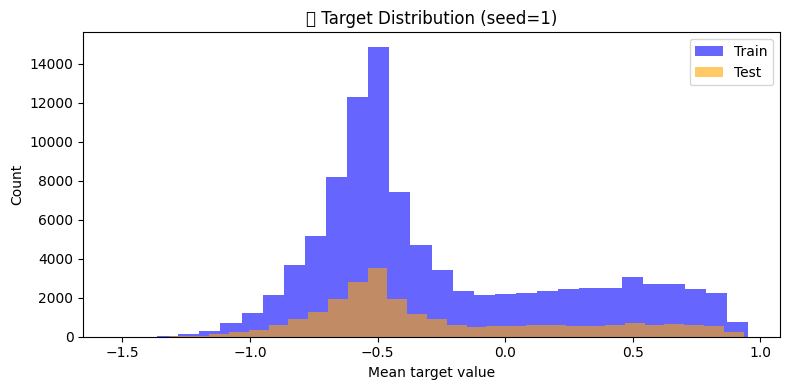

✅ Train and test are properly separated (no overlap).


Epochs:  16%|█▌        | 16/100 [00:00<00:02, 31.76it/s]

Epoch [10/100], Loss: 0.2257


Epochs:  24%|██▍       | 24/100 [00:00<00:02, 32.45it/s]

Epoch [20/100], Loss: 0.2260


Epochs:  36%|███▌      | 36/100 [00:01<00:01, 32.50it/s]

Epoch [30/100], Loss: 0.2049


Epochs:  44%|████▍     | 44/100 [00:01<00:01, 32.32it/s]

Epoch [40/100], Loss: 0.1960


Epochs:  56%|█████▌    | 56/100 [00:01<00:01, 32.23it/s]

Epoch [50/100], Loss: 0.1798


Epochs:  64%|██████▍   | 64/100 [00:01<00:01, 32.31it/s]

Epoch [60/100], Loss: 0.1407


Epochs:  76%|███████▌  | 76/100 [00:02<00:00, 31.99it/s]

Epoch [70/100], Loss: 0.1005


Epochs:  84%|████████▍ | 84/100 [00:02<00:00, 31.93it/s]

Epoch [80/100], Loss: 0.1006


Epochs:  96%|█████████▌| 96/100 [00:02<00:00, 33.04it/s]

Epoch [90/100], Loss: 0.0872


Epochs: 100%|██████████| 100/100 [00:03<00:00, 32.28it/s]


Epoch [100/100], Loss: 0.0856

📊 Metrics:
{'MSE': 0.08497525751590729, 'MAE': 0.20599639415740967, 'R2': 0.6560282111167908}

🔁 Run 3 / 20 (seed = 2)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


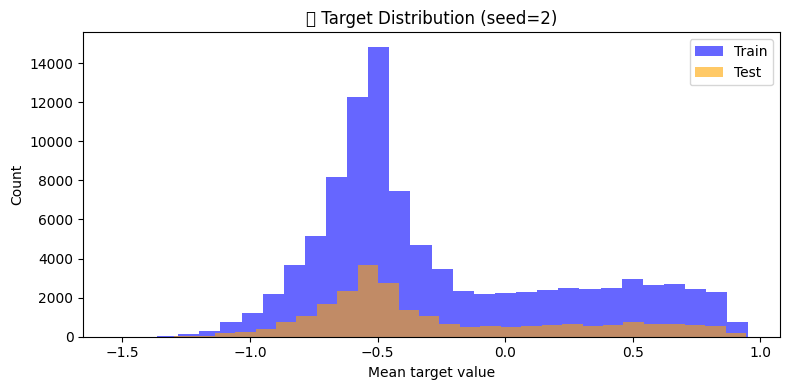

✅ Train and test are properly separated (no overlap).


Epochs:  16%|█▌        | 16/100 [00:00<00:02, 33.44it/s]

Epoch [10/100], Loss: 0.3841


Epochs:  24%|██▍       | 24/100 [00:00<00:02, 33.65it/s]

Epoch [20/100], Loss: 0.2561


Epochs:  36%|███▌      | 36/100 [00:01<00:01, 34.56it/s]

Epoch [30/100], Loss: 0.2158


Epochs:  44%|████▍     | 44/100 [00:01<00:01, 34.18it/s]

Epoch [40/100], Loss: 0.2031


Epochs:  56%|█████▌    | 56/100 [00:01<00:01, 34.38it/s]

Epoch [50/100], Loss: 0.1843


Epochs:  64%|██████▍   | 64/100 [00:01<00:01, 33.68it/s]

Epoch [60/100], Loss: 0.1554


Epochs:  76%|███████▌  | 76/100 [00:02<00:00, 33.88it/s]

Epoch [70/100], Loss: 0.1166


Epochs:  84%|████████▍ | 84/100 [00:02<00:00, 33.30it/s]

Epoch [80/100], Loss: 0.0976


Epochs:  96%|█████████▌| 96/100 [00:02<00:00, 33.40it/s]

Epoch [90/100], Loss: 0.0916


Epochs: 100%|██████████| 100/100 [00:02<00:00, 33.71it/s]


Epoch [100/100], Loss: 0.0882

📊 Metrics:
{'MSE': 0.08975418657064438, 'MAE': 0.21310748159885406, 'R2': 0.64117431640625}

🔁 Run 4 / 20 (seed = 3)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


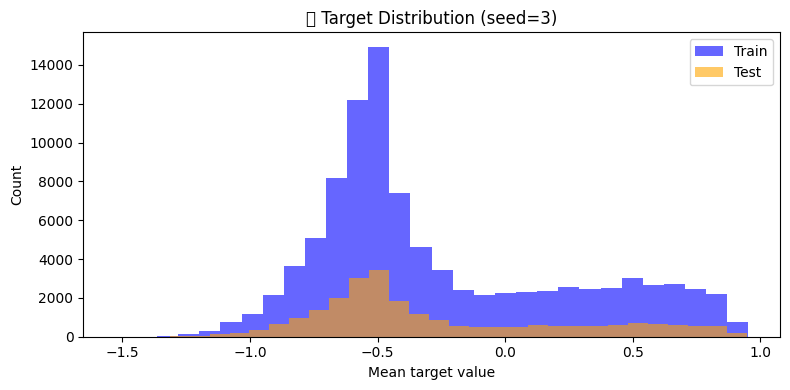

✅ Train and test are properly separated (no overlap).


Epochs:  14%|█▍        | 14/100 [00:00<00:02, 31.02it/s]

Epoch [10/100], Loss: 0.3249


Epochs:  26%|██▌       | 26/100 [00:00<00:02, 31.53it/s]

Epoch [20/100], Loss: 0.2177


Epochs:  34%|███▍      | 34/100 [00:01<00:02, 31.92it/s]

Epoch [30/100], Loss: 0.1993


Epochs:  46%|████▌     | 46/100 [00:01<00:01, 32.77it/s]

Epoch [40/100], Loss: 0.1701


Epochs:  54%|█████▍    | 54/100 [00:01<00:01, 32.95it/s]

Epoch [50/100], Loss: 0.1409


Epochs:  66%|██████▌   | 66/100 [00:02<00:01, 32.92it/s]

Epoch [60/100], Loss: 0.1127


Epochs:  74%|███████▍  | 74/100 [00:02<00:00, 32.62it/s]

Epoch [70/100], Loss: 0.0956


Epochs:  86%|████████▌ | 86/100 [00:02<00:00, 31.30it/s]

Epoch [80/100], Loss: 0.0893


Epochs:  94%|█████████▍| 94/100 [00:02<00:00, 29.99it/s]

Epoch [90/100], Loss: 0.0872


Epochs: 100%|██████████| 100/100 [00:03<00:00, 31.64it/s]


Epoch [100/100], Loss: 0.0849

📊 Metrics:
{'MSE': 0.08432552218437195, 'MAE': 0.2042553424835205, 'R2': 0.6610426902770996}

🔁 Run 5 / 20 (seed = 4)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


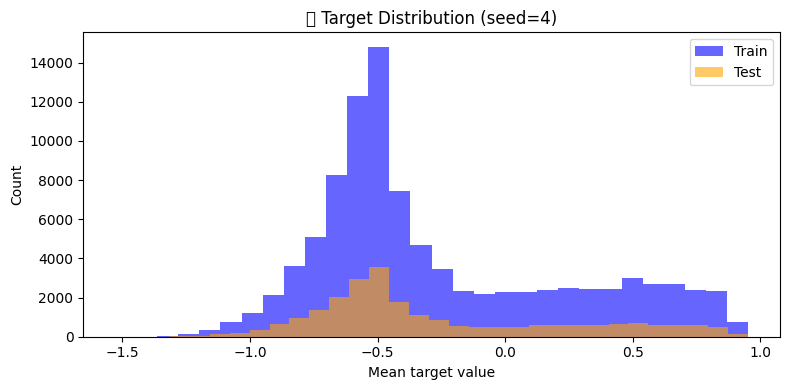

✅ Train and test are properly separated (no overlap).


Epochs:  13%|█▎        | 13/100 [00:00<00:03, 26.02it/s]

Epoch [10/100], Loss: 0.3878


Epochs:  22%|██▏       | 22/100 [00:00<00:03, 23.29it/s]

Epoch [20/100], Loss: 0.2394


Epochs:  32%|███▏      | 32/100 [00:01<00:04, 15.12it/s]

Epoch [30/100], Loss: 0.1909


Epochs:  42%|████▏     | 42/100 [00:02<00:03, 17.31it/s]

Epoch [40/100], Loss: 0.1765


Epochs:  52%|█████▏    | 52/100 [00:02<00:02, 17.14it/s]

Epoch [50/100], Loss: 0.1461


Epochs:  62%|██████▏   | 62/100 [00:03<00:01, 20.37it/s]

Epoch [60/100], Loss: 0.1157


Epochs:  73%|███████▎  | 73/100 [00:03<00:01, 18.58it/s]

Epoch [70/100], Loss: 0.0974


Epochs:  83%|████████▎ | 83/100 [00:04<00:01, 16.01it/s]

Epoch [80/100], Loss: 0.0903


Epochs:  92%|█████████▏| 92/100 [00:04<00:00, 17.23it/s]

Epoch [90/100], Loss: 0.0871


Epochs: 100%|██████████| 100/100 [00:05<00:00, 18.69it/s]


Epoch [100/100], Loss: 0.0855

📊 Metrics:
{'MSE': 0.08630464226007462, 'MAE': 0.2113124281167984, 'R2': 0.6509292125701904}

🔁 Run 6 / 20 (seed = 5)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


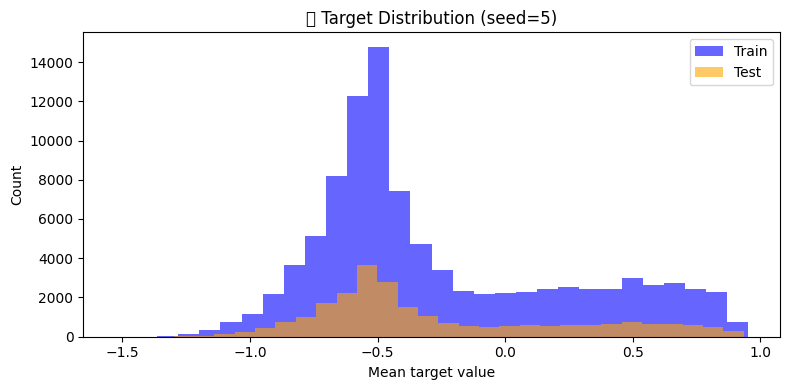

✅ Train and test are properly separated (no overlap).


Epochs:  13%|█▎        | 13/100 [00:00<00:05, 16.09it/s]

Epoch [10/100], Loss: 0.3563


Epochs:  22%|██▏       | 22/100 [00:01<00:03, 20.47it/s]

Epoch [20/100], Loss: 0.2053


Epochs:  34%|███▍      | 34/100 [00:01<00:03, 20.65it/s]

Epoch [30/100], Loss: 0.2016


Epochs:  43%|████▎     | 43/100 [00:02<00:02, 19.31it/s]

Epoch [40/100], Loss: 0.1730


Epochs:  52%|█████▏    | 52/100 [00:02<00:02, 20.99it/s]

Epoch [50/100], Loss: 0.1517


Epochs:  64%|██████▍   | 64/100 [00:03<00:01, 21.68it/s]

Epoch [60/100], Loss: 0.1236


Epochs:  73%|███████▎  | 73/100 [00:03<00:01, 19.52it/s]

Epoch [70/100], Loss: 0.1011


Epochs:  83%|████████▎ | 83/100 [00:04<00:00, 20.13it/s]

Epoch [80/100], Loss: 0.0909


Epochs:  92%|█████████▏| 92/100 [00:04<00:00, 21.61it/s]

Epoch [90/100], Loss: 0.0866


Epochs: 100%|██████████| 100/100 [00:04<00:00, 20.08it/s]


Epoch [100/100], Loss: 0.0836

📊 Metrics:
{'MSE': 0.08442399650812149, 'MAE': 0.2030065953731537, 'R2': 0.6582920551300049}

🔁 Run 7 / 20 (seed = 6)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


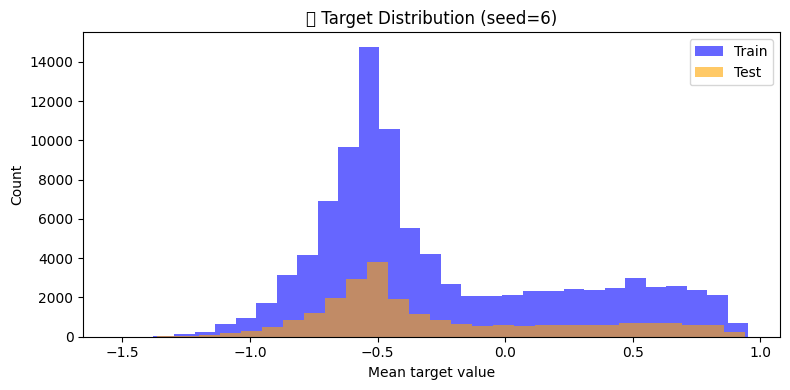

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:03, 24.53it/s]

Epoch [10/100], Loss: 0.3589


Epochs:  24%|██▍       | 24/100 [00:01<00:03, 22.32it/s]

Epoch [20/100], Loss: 0.2541


Epochs:  33%|███▎      | 33/100 [00:01<00:03, 22.12it/s]

Epoch [30/100], Loss: 0.2069


Epochs:  42%|████▏     | 42/100 [00:01<00:02, 22.16it/s]

Epoch [40/100], Loss: 0.1971


Epochs:  54%|█████▍    | 54/100 [00:02<00:02, 20.97it/s]

Epoch [50/100], Loss: 0.1773


Epochs:  63%|██████▎   | 63/100 [00:02<00:01, 21.83it/s]

Epoch [60/100], Loss: 0.1470


Epochs:  72%|███████▏  | 72/100 [00:03<00:01, 20.96it/s]

Epoch [70/100], Loss: 0.1133


Epochs:  84%|████████▍ | 84/100 [00:03<00:00, 21.66it/s]

Epoch [80/100], Loss: 0.0961


Epochs:  93%|█████████▎| 93/100 [00:04<00:00, 21.26it/s]

Epoch [90/100], Loss: 0.0897


Epochs: 100%|██████████| 100/100 [00:04<00:00, 21.86it/s]


Epoch [100/100], Loss: 0.0877

📊 Metrics:
{'MSE': 0.08696594834327698, 'MAE': 0.2065480649471283, 'R2': 0.6475884914398193}

🔁 Run 8 / 20 (seed = 7)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


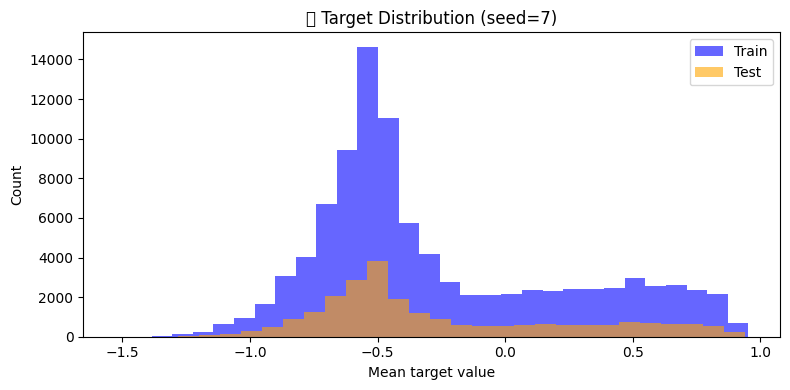

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:03, 22.19it/s]

Epoch [10/100], Loss: 0.3640


Epochs:  22%|██▏       | 22/100 [00:01<00:04, 17.27it/s]

Epoch [20/100], Loss: 0.2888


Epochs:  32%|███▏      | 32/100 [00:01<00:03, 18.68it/s]

Epoch [30/100], Loss: 0.2245


Epochs:  44%|████▍     | 44/100 [00:02<00:02, 19.23it/s]

Epoch [40/100], Loss: 0.2002


Epochs:  52%|█████▏    | 52/100 [00:02<00:02, 17.19it/s]

Epoch [50/100], Loss: 0.1847


Epochs:  62%|██████▏   | 62/100 [00:03<00:02, 16.93it/s]

Epoch [60/100], Loss: 0.1633


Epochs:  72%|███████▏  | 72/100 [00:03<00:01, 17.21it/s]

Epoch [70/100], Loss: 0.1346


Epochs:  83%|████████▎ | 83/100 [00:04<00:00, 18.42it/s]

Epoch [80/100], Loss: 0.1079


Epochs:  94%|█████████▍| 94/100 [00:05<00:00, 18.36it/s]

Epoch [90/100], Loss: 0.0937


Epochs: 100%|██████████| 100/100 [00:05<00:00, 18.18it/s]


Epoch [100/100], Loss: 0.0892

📊 Metrics:
{'MSE': 0.08537754416465759, 'MAE': 0.2068028599023819, 'R2': 0.6529425382614136}

🔁 Run 9 / 20 (seed = 8)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


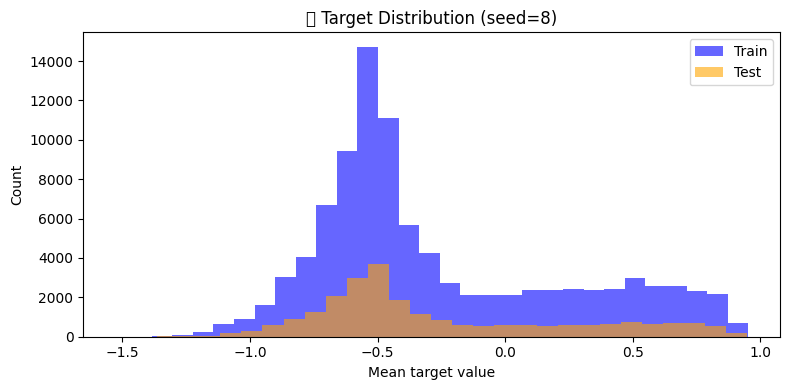

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:04, 19.92it/s]

Epoch [10/100], Loss: 0.4388


Epochs:  22%|██▏       | 22/100 [00:01<00:04, 17.45it/s]

Epoch [20/100], Loss: 0.2529


Epochs:  33%|███▎      | 33/100 [00:01<00:03, 17.75it/s]

Epoch [30/100], Loss: 0.2067


Epochs:  43%|████▎     | 43/100 [00:02<00:03, 17.97it/s]

Epoch [40/100], Loss: 0.1945


Epochs:  53%|█████▎    | 53/100 [00:02<00:02, 19.01it/s]

Epoch [50/100], Loss: 0.1768


Epochs:  63%|██████▎   | 63/100 [00:03<00:02, 16.69it/s]

Epoch [60/100], Loss: 0.1519


Epochs:  73%|███████▎  | 73/100 [00:04<00:01, 18.04it/s]

Epoch [70/100], Loss: 0.1235


Epochs:  83%|████████▎ | 83/100 [00:04<00:00, 19.48it/s]

Epoch [80/100], Loss: 0.1008


Epochs:  93%|█████████▎| 93/100 [00:05<00:00, 17.69it/s]

Epoch [90/100], Loss: 0.0897


Epochs: 100%|██████████| 100/100 [00:05<00:00, 17.94it/s]


Epoch [100/100], Loss: 0.0852

📊 Metrics:
{'MSE': 0.0866725817322731, 'MAE': 0.21097134053707123, 'R2': 0.6544018387794495}

🔁 Run 10 / 20 (seed = 9)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


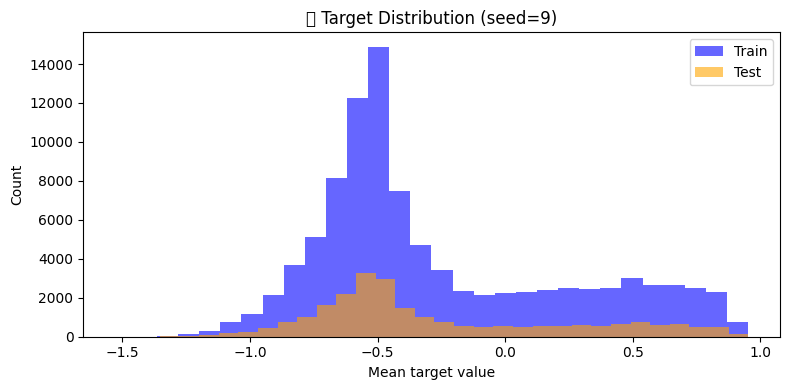

✅ Train and test are properly separated (no overlap).


Epochs:  13%|█▎        | 13/100 [00:00<00:05, 15.59it/s]

Epoch [10/100], Loss: 0.3164


Epochs:  23%|██▎       | 23/100 [00:01<00:05, 14.64it/s]

Epoch [20/100], Loss: 0.2051


Epochs:  33%|███▎      | 33/100 [00:02<00:03, 17.20it/s]

Epoch [30/100], Loss: 0.1821


Epochs:  42%|████▏     | 42/100 [00:02<00:03, 17.43it/s]

Epoch [40/100], Loss: 0.1533


Epochs:  53%|█████▎    | 53/100 [00:03<00:02, 19.86it/s]

Epoch [50/100], Loss: 0.1222


Epochs:  63%|██████▎   | 63/100 [00:03<00:02, 17.04it/s]

Epoch [60/100], Loss: 0.0992


Epochs:  72%|███████▏  | 72/100 [00:04<00:01, 18.68it/s]

Epoch [70/100], Loss: 0.0906


Epochs:  82%|████████▏ | 82/100 [00:04<00:01, 17.64it/s]

Epoch [80/100], Loss: 0.0859


Epochs:  93%|█████████▎| 93/100 [00:05<00:00, 18.95it/s]

Epoch [90/100], Loss: 0.0866


Epochs: 100%|██████████| 100/100 [00:05<00:00, 17.29it/s]


Epoch [100/100], Loss: 0.0835

📊 Metrics:
{'MSE': 0.08412213623523712, 'MAE': 0.20688074827194214, 'R2': 0.6610313653945923}

🔁 Run 11 / 20 (seed = 10)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


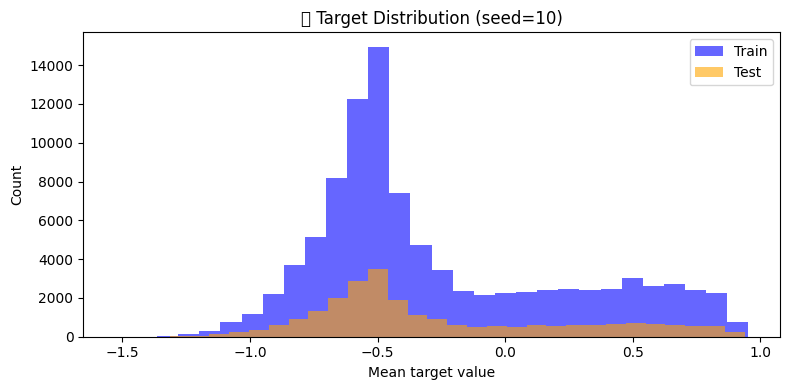

✅ Train and test are properly separated (no overlap).


Epochs:  14%|█▍        | 14/100 [00:00<00:04, 19.09it/s]

Epoch [10/100], Loss: 0.3168


Epochs:  22%|██▏       | 22/100 [00:05<00:25,  3.01it/s]

Epoch [20/100], Loss: 0.2252


Epochs:  33%|███▎      | 33/100 [00:05<00:06, 10.08it/s]

Epoch [30/100], Loss: 0.2014


Epochs:  43%|████▎     | 43/100 [00:06<00:03, 16.64it/s]

Epoch [40/100], Loss: 0.1905


Epochs:  52%|█████▏    | 52/100 [00:06<00:02, 17.04it/s]

Epoch [50/100], Loss: 0.1689


Epochs:  64%|██████▍   | 64/100 [00:07<00:01, 20.21it/s]

Epoch [60/100], Loss: 0.1370


Epochs:  73%|███████▎  | 73/100 [00:07<00:01, 20.90it/s]

Epoch [70/100], Loss: 0.1063


Epochs:  84%|████████▍ | 84/100 [00:08<00:00, 20.04it/s]

Epoch [80/100], Loss: 0.0933


Epochs:  93%|█████████▎| 93/100 [00:08<00:00, 20.15it/s]

Epoch [90/100], Loss: 0.0884


Epochs: 100%|██████████| 100/100 [00:09<00:00, 11.03it/s]


Epoch [100/100], Loss: 0.0856

📊 Metrics:
{'MSE': 0.08754733949899673, 'MAE': 0.2064083218574524, 'R2': 0.6499581336975098}

🔁 Run 12 / 20 (seed = 11)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


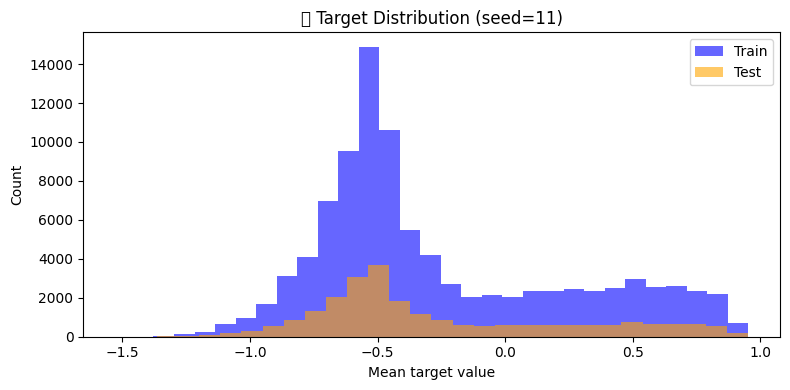

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:03, 22.69it/s]

Epoch [10/100], Loss: 0.3915


Epochs:  24%|██▍       | 24/100 [00:01<00:03, 21.24it/s]

Epoch [20/100], Loss: 0.2345


Epochs:  33%|███▎      | 33/100 [00:01<00:03, 21.24it/s]

Epoch [30/100], Loss: 0.1961


Epochs:  42%|████▏     | 42/100 [00:01<00:02, 20.73it/s]

Epoch [40/100], Loss: 0.1881


Epochs:  54%|█████▍    | 54/100 [00:02<00:02, 21.53it/s]

Epoch [50/100], Loss: 0.1658


Epochs:  63%|██████▎   | 63/100 [00:02<00:01, 19.84it/s]

Epoch [60/100], Loss: 0.1390


Epochs:  74%|███████▍  | 74/100 [00:03<00:01, 20.60it/s]

Epoch [70/100], Loss: 0.1108


Epochs:  82%|████████▏ | 82/100 [00:03<00:00, 19.11it/s]

Epoch [80/100], Loss: 0.0940


Epochs:  94%|█████████▍| 94/100 [00:04<00:00, 20.78it/s]

Epoch [90/100], Loss: 0.0880


Epochs: 100%|██████████| 100/100 [00:04<00:00, 20.56it/s]


Epoch [100/100], Loss: 0.0847

📊 Metrics:
{'MSE': 0.08398457616567612, 'MAE': 0.20362769067287445, 'R2': 0.6587687730789185}

🔁 Run 13 / 20 (seed = 12)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


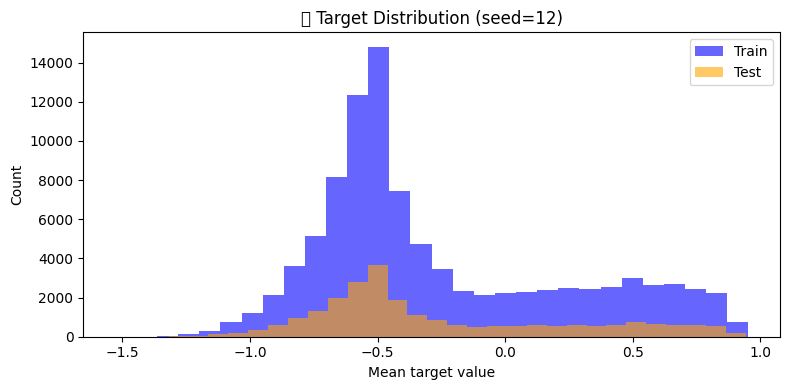

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:03, 22.57it/s]

Epoch [10/100], Loss: 0.3507


Epochs:  24%|██▍       | 24/100 [00:01<00:03, 20.86it/s]

Epoch [20/100], Loss: 0.2390


Epochs:  32%|███▏      | 32/100 [00:01<00:03, 19.76it/s]

Epoch [30/100], Loss: 0.1999


Epochs:  41%|████      | 41/100 [00:01<00:02, 20.26it/s]

Epoch [40/100], Loss: 0.1815


Epochs:  53%|█████▎    | 53/100 [00:02<00:02, 20.26it/s]

Epoch [50/100], Loss: 0.1555


Epochs:  62%|██████▏   | 62/100 [00:03<00:01, 20.05it/s]

Epoch [60/100], Loss: 0.1225


Epochs:  71%|███████   | 71/100 [00:03<00:01, 21.25it/s]

Epoch [70/100], Loss: 0.0982


Epochs:  82%|████████▏ | 82/100 [00:04<00:00, 19.72it/s]

Epoch [80/100], Loss: 0.0900


Epochs:  94%|█████████▍| 94/100 [00:04<00:00, 22.20it/s]

Epoch [90/100], Loss: 0.0861


Epochs: 100%|██████████| 100/100 [00:04<00:00, 20.65it/s]


Epoch [100/100], Loss: 0.0838

📊 Metrics:
{'MSE': 0.08743622153997421, 'MAE': 0.2053368091583252, 'R2': 0.6472204923629761}

🔁 Run 14 / 20 (seed = 13)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


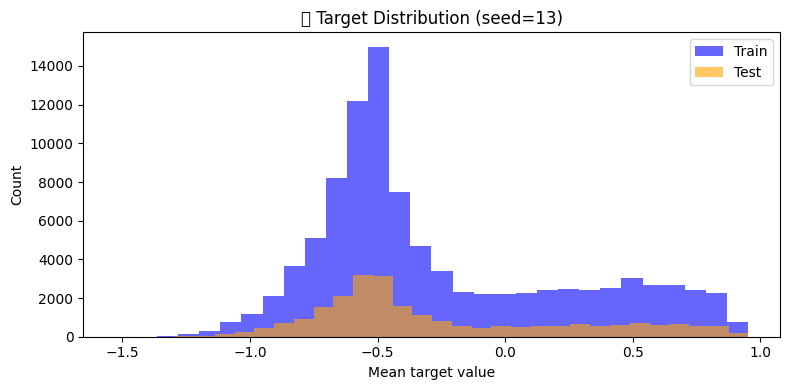

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:03, 24.58it/s]

Epoch [10/100], Loss: 0.4302


Epochs:  24%|██▍       | 24/100 [00:01<00:03, 22.41it/s]

Epoch [20/100], Loss: 0.2987


Epochs:  33%|███▎      | 33/100 [00:01<00:03, 21.69it/s]

Epoch [30/100], Loss: 0.2324


Epochs:  42%|████▏     | 42/100 [00:01<00:02, 22.54it/s]

Epoch [40/100], Loss: 0.2091


Epochs:  54%|█████▍    | 54/100 [00:02<00:02, 22.33it/s]

Epoch [50/100], Loss: 0.2049


Epochs:  63%|██████▎   | 63/100 [00:02<00:01, 20.86it/s]

Epoch [60/100], Loss: 0.1968


Epochs:  72%|███████▏  | 72/100 [00:03<00:01, 21.69it/s]

Epoch [70/100], Loss: 0.1896


Epochs:  84%|████████▍ | 84/100 [00:03<00:00, 22.75it/s]

Epoch [80/100], Loss: 0.1739


Epochs:  93%|█████████▎| 93/100 [00:04<00:00, 21.06it/s]

Epoch [90/100], Loss: 0.1461


Epochs: 100%|██████████| 100/100 [00:04<00:00, 21.90it/s]


Epoch [100/100], Loss: 0.1156

📊 Metrics:
{'MSE': 0.11359258741140366, 'MAE': 0.2513997256755829, 'R2': 0.5452759861946106}

🔁 Run 15 / 20 (seed = 14)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


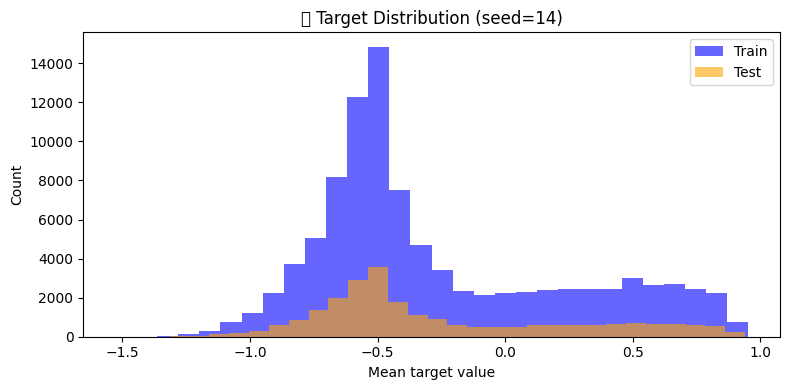

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:03, 23.82it/s]

Epoch [10/100], Loss: 0.3215


Epochs:  24%|██▍       | 24/100 [00:01<00:03, 20.75it/s]

Epoch [20/100], Loss: 0.2093


Epochs:  33%|███▎      | 33/100 [00:01<00:03, 19.82it/s]

Epoch [30/100], Loss: 0.1886


Epochs:  44%|████▍     | 44/100 [00:02<00:02, 21.07it/s]

Epoch [40/100], Loss: 0.1559


Epochs:  53%|█████▎    | 53/100 [00:02<00:02, 20.46it/s]

Epoch [50/100], Loss: 0.1289


Epochs:  62%|██████▏   | 62/100 [00:02<00:01, 20.27it/s]

Epoch [60/100], Loss: 0.1067


Epochs:  74%|███████▍  | 74/100 [00:03<00:01, 21.32it/s]

Epoch [70/100], Loss: 0.0933


Epochs:  83%|████████▎ | 83/100 [00:04<00:00, 20.50it/s]

Epoch [80/100], Loss: 0.0881


Epochs:  92%|█████████▏| 92/100 [00:04<00:00, 22.23it/s]

Epoch [90/100], Loss: 0.0853


Epochs: 100%|██████████| 100/100 [00:04<00:00, 20.93it/s]


Epoch [100/100], Loss: 0.0832

📊 Metrics:
{'MSE': 0.08529064804315567, 'MAE': 0.2071421593427658, 'R2': 0.6589486598968506}

🔁 Run 16 / 20 (seed = 15)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


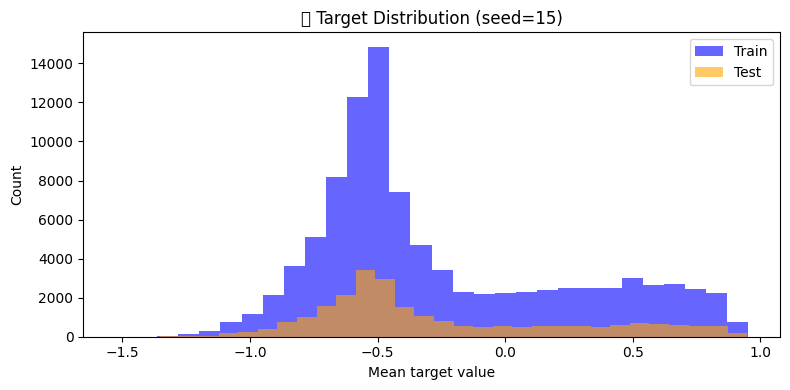

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:04, 20.46it/s]

Epoch [10/100], Loss: 0.3837


Epochs:  21%|██        | 21/100 [00:01<00:03, 20.45it/s]

Epoch [20/100], Loss: 0.2477


Epochs:  33%|███▎      | 33/100 [00:01<00:03, 22.08it/s]

Epoch [30/100], Loss: 0.2078


Epochs:  42%|████▏     | 42/100 [00:01<00:02, 21.27it/s]

Epoch [40/100], Loss: 0.1949


Epochs:  53%|█████▎    | 53/100 [00:02<00:02, 20.48it/s]

Epoch [50/100], Loss: 0.1712


Epochs:  62%|██████▏   | 62/100 [00:02<00:01, 20.87it/s]

Epoch [60/100], Loss: 0.1371


Epochs:  74%|███████▍  | 74/100 [00:03<00:01, 20.99it/s]

Epoch [70/100], Loss: 0.1037


Epochs:  83%|████████▎ | 83/100 [00:04<00:00, 20.54it/s]

Epoch [80/100], Loss: 0.0920


Epochs:  92%|█████████▏| 92/100 [00:04<00:00, 22.56it/s]

Epoch [90/100], Loss: 0.0872


Epochs: 100%|██████████| 100/100 [00:04<00:00, 20.76it/s]


Epoch [100/100], Loss: 0.0864

📊 Metrics:
{'MSE': 0.0847473293542862, 'MAE': 0.21072612702846527, 'R2': 0.6588865518569946}

🔁 Run 17 / 20 (seed = 16)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


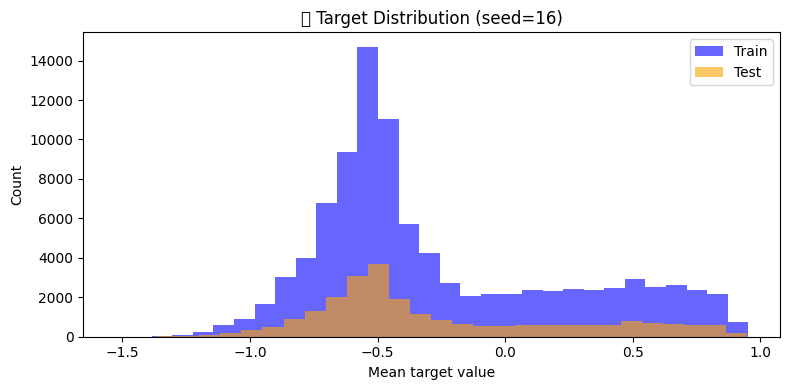

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:03, 23.51it/s]

Epoch [10/100], Loss: 0.3784


Epochs:  24%|██▍       | 24/100 [00:01<00:03, 22.45it/s]

Epoch [20/100], Loss: 0.2849


Epochs:  33%|███▎      | 33/100 [00:01<00:03, 21.51it/s]

Epoch [30/100], Loss: 0.2269


Epochs:  45%|████▌     | 45/100 [00:03<00:05, 10.02it/s]

Epoch [40/100], Loss: 0.2029


Epochs:  54%|█████▍    | 54/100 [00:04<00:02, 15.45it/s]

Epoch [50/100], Loss: 0.1855


Epochs:  63%|██████▎   | 63/100 [00:04<00:01, 19.63it/s]

Epoch [60/100], Loss: 0.1590


Epochs:  75%|███████▌  | 75/100 [00:05<00:01, 21.99it/s]

Epoch [70/100], Loss: 0.1249


Epochs:  84%|████████▍ | 84/100 [00:05<00:00, 20.93it/s]

Epoch [80/100], Loss: 0.0957


Epochs:  93%|█████████▎| 93/100 [00:05<00:00, 22.07it/s]

Epoch [90/100], Loss: 0.0866


Epochs: 100%|██████████| 100/100 [00:06<00:00, 16.12it/s]


Epoch [100/100], Loss: 0.0830

📊 Metrics:
{'MSE': 0.08188652247190475, 'MAE': 0.20224210619926453, 'R2': 0.6678698658943176}

🔁 Run 18 / 20 (seed = 17)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


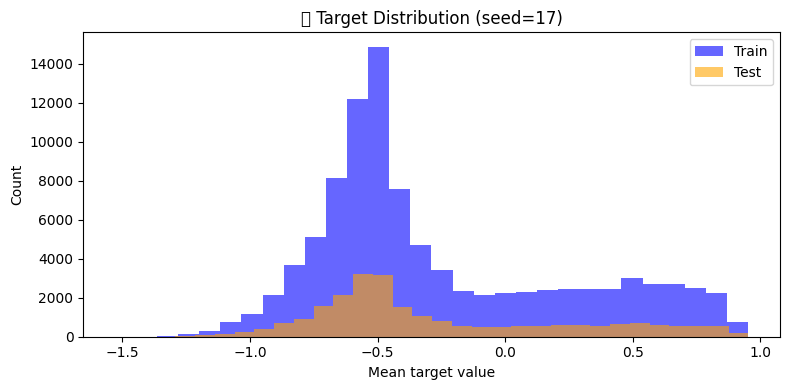

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:03, 23.83it/s]

Epoch [10/100], Loss: 0.2796


Epochs:  22%|██▏       | 22/100 [00:01<00:04, 18.05it/s]

Epoch [20/100], Loss: 0.2348


Epochs:  32%|███▏      | 32/100 [00:01<00:03, 18.33it/s]

Epoch [30/100], Loss: 0.2016


Epochs:  43%|████▎     | 43/100 [00:02<00:02, 20.82it/s]

Epoch [40/100], Loss: 0.1878


Epochs:  54%|█████▍    | 54/100 [00:02<00:02, 20.72it/s]

Epoch [50/100], Loss: 0.1607


Epochs:  63%|██████▎   | 63/100 [00:03<00:01, 19.73it/s]

Epoch [60/100], Loss: 0.1219


Epochs:  72%|███████▏  | 72/100 [00:03<00:01, 18.09it/s]

Epoch [70/100], Loss: 0.0966


Epochs:  82%|████████▏ | 82/100 [00:04<00:00, 18.69it/s]

Epoch [80/100], Loss: 0.0885


Epochs:  92%|█████████▏| 92/100 [00:04<00:00, 17.40it/s]

Epoch [90/100], Loss: 0.0896


Epochs: 100%|██████████| 100/100 [00:05<00:00, 18.85it/s]


Epoch [100/100], Loss: 0.0845

📊 Metrics:
{'MSE': 0.0843469575047493, 'MAE': 0.20227180421352386, 'R2': 0.6603056192398071}

🔁 Run 19 / 20 (seed = 18)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


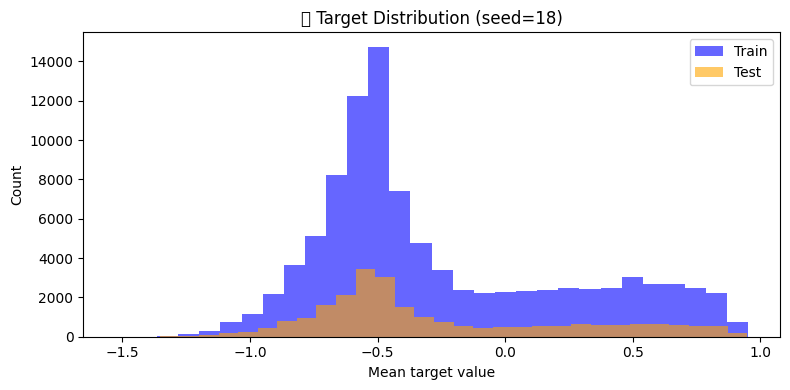

✅ Train and test are properly separated (no overlap).


Epochs:  13%|█▎        | 13/100 [00:00<00:04, 18.68it/s]

Epoch [10/100], Loss: 0.3601


Epochs:  23%|██▎       | 23/100 [00:01<00:03, 19.39it/s]

Epoch [20/100], Loss: 0.2490


Epochs:  34%|███▍      | 34/100 [00:01<00:03, 19.02it/s]

Epoch [30/100], Loss: 0.2043


Epochs:  42%|████▏     | 42/100 [00:02<00:03, 19.22it/s]

Epoch [40/100], Loss: 0.1835


Epochs:  53%|█████▎    | 53/100 [00:02<00:02, 18.69it/s]

Epoch [50/100], Loss: 0.1534


Epochs:  63%|██████▎   | 63/100 [00:03<00:02, 16.82it/s]

Epoch [60/100], Loss: 0.1242


Epochs:  72%|███████▏  | 72/100 [00:03<00:01, 19.25it/s]

Epoch [70/100], Loss: 0.1019


Epochs:  84%|████████▍ | 84/100 [00:04<00:00, 20.39it/s]

Epoch [80/100], Loss: 0.0909


Epochs:  93%|█████████▎| 93/100 [00:04<00:00, 21.06it/s]

Epoch [90/100], Loss: 0.0873


Epochs: 100%|██████████| 100/100 [00:05<00:00, 18.83it/s]


Epoch [100/100], Loss: 0.0852

📊 Metrics:
{'MSE': 0.08564190566539764, 'MAE': 0.20536839962005615, 'R2': 0.6566221714019775}

🔁 Run 20 / 20 (seed = 19)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_2024/1748701174.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/Wind_pressure_prediction_2025/environment/linux_wpp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


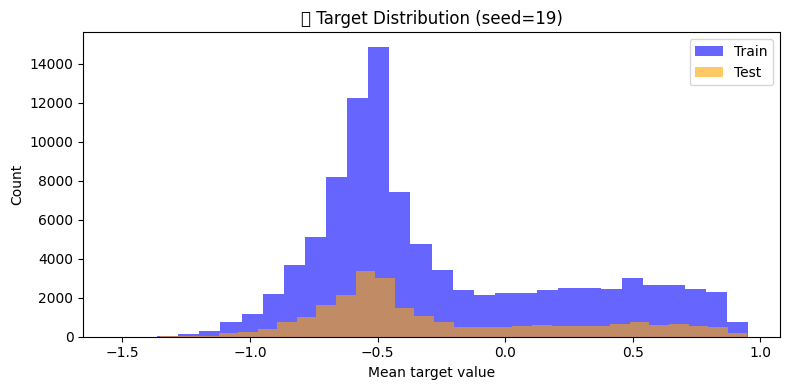

✅ Train and test are properly separated (no overlap).


Epochs:  14%|█▍        | 14/100 [00:00<00:03, 22.35it/s]

Epoch [10/100], Loss: 0.3751


Epochs:  23%|██▎       | 23/100 [00:01<00:03, 19.67it/s]

Epoch [20/100], Loss: 0.2082


Epochs:  32%|███▏      | 32/100 [00:01<00:03, 18.30it/s]

Epoch [30/100], Loss: 0.1918


Epochs:  44%|████▍     | 44/100 [00:02<00:03, 18.48it/s]

Epoch [40/100], Loss: 0.1563


Epochs:  52%|█████▏    | 52/100 [00:02<00:02, 17.70it/s]

Epoch [50/100], Loss: 0.1266


Epochs:  62%|██████▏   | 62/100 [00:03<00:01, 19.42it/s]

Epoch [60/100], Loss: 0.1008


Epochs:  73%|███████▎  | 73/100 [00:03<00:01, 19.60it/s]

Epoch [70/100], Loss: 0.0903


Epochs:  83%|████████▎ | 83/100 [00:04<00:00, 18.64it/s]

Epoch [80/100], Loss: 0.0862


Epochs:  93%|█████████▎| 93/100 [00:04<00:00, 20.41it/s]

Epoch [90/100], Loss: 0.0845


Epochs: 100%|██████████| 100/100 [00:05<00:00, 18.75it/s]

Epoch [100/100], Loss: 0.0865

📊 Metrics:
{'MSE': 0.08273690193891525, 'MAE': 0.20186610519886017, 'R2': 0.6668651103973389}
📁 Best weights saved to: /mnt/d/projects/wind_pressure_prediction_2025/final_models/config_001/best_model_weights_mlp_64h_7e-03lr_32bs_100ep_Tanh_Adam.pt
🏆 Best run: run_seed_0 with R2 = 0.6701
   R2   = 0.6701
   MAE  = 0.2000
   MSE  = 0.080851


In [22]:
# 📁 src/tuning/run_experiments.py
# ➤ Run MLP training multiple times with different random seeds to assess stability
# ➤ Track and save best model based on R² score
# ➤ Store metrics for each run, save best weights and evaluation report


# 🧠 Prepare model
# 📌 Fixed parameters
EPOCHS = 100
OUTPUT_DIM = 1
N_RUNS = 20  # Total number of runs

# 📊 Containers to collect results
results_all = []
results_header = ["run", "run_id", "R2", "MAE", "MSE"]
best_r2 = -float("inf")
best_model = None
best_metrics = None
best_run_id = None
train_loss_history = [] 
weights_registry = {}  # run_id -> weights
weights_registry.clear()


# 🔁 Run the same config with different random seeds
for seed in range(N_RUNS):
    print(f"\n🔁 Run {seed + 1} / {N_RUNS} (seed = {seed})")

    # 🏃 Train model with current seed
    run_id, metrics = train_mlp(
        hidden_dim=config["hidden_dim"],
        lr=config["lr"],
        batch_size=config["batch_size"],
        epochs=config["epochs"],
        output_dim=config["output_dim"],
        activation_fn=config["activation_fn"],
        optimizer_name=config["optimizer_name"],
        seed=seed
    )

    # 📥 Collect result for this run
    results_all.append({
        "run": seed,
        "run_id": run_id,
        "R2": metrics["R2"],
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"]
    })

    # 🏆 Check if it's the best so far
    if metrics["R2"] > best_r2:
        best_r2 = metrics["R2"]
        best_metrics = metrics
        best_run_id = run_id

# 💾 Save best model weights
best_weights = weights_registry[best_run_id]
weights_save_path = os.path.join(SAVE_ROOT, f"best_model_weights_{arch_label}.pt")
torch.save(best_weights, weights_save_path)
print(f"📁 Best weights saved to: {weights_save_path}")

# 💾 Save full metrics log
results_csv_path = os.path.join(SAVE_ROOT, f"results_{arch_label}.csv")
df_results = pd.DataFrame(results_all, columns=results_header)
df_results.to_csv(results_csv_path, index=False)

# 💾 Save best run's metrics
metrics_json_path = os.path.join(SAVE_ROOT, f"metrics_best_{arch_label}.json")
with open(metrics_json_path, "w") as f:
    json.dump(best_metrics, f, indent=4)

print(f"🏆 Best run: {best_run_id} with R2 = {best_r2:.4f}")
print(f"   R2   = {best_metrics['R2']:.4f}")
print(f"   MAE  = {best_metrics['MAE']:.4f}")
print(f"   MSE  = {best_metrics['MSE']:.6f}")


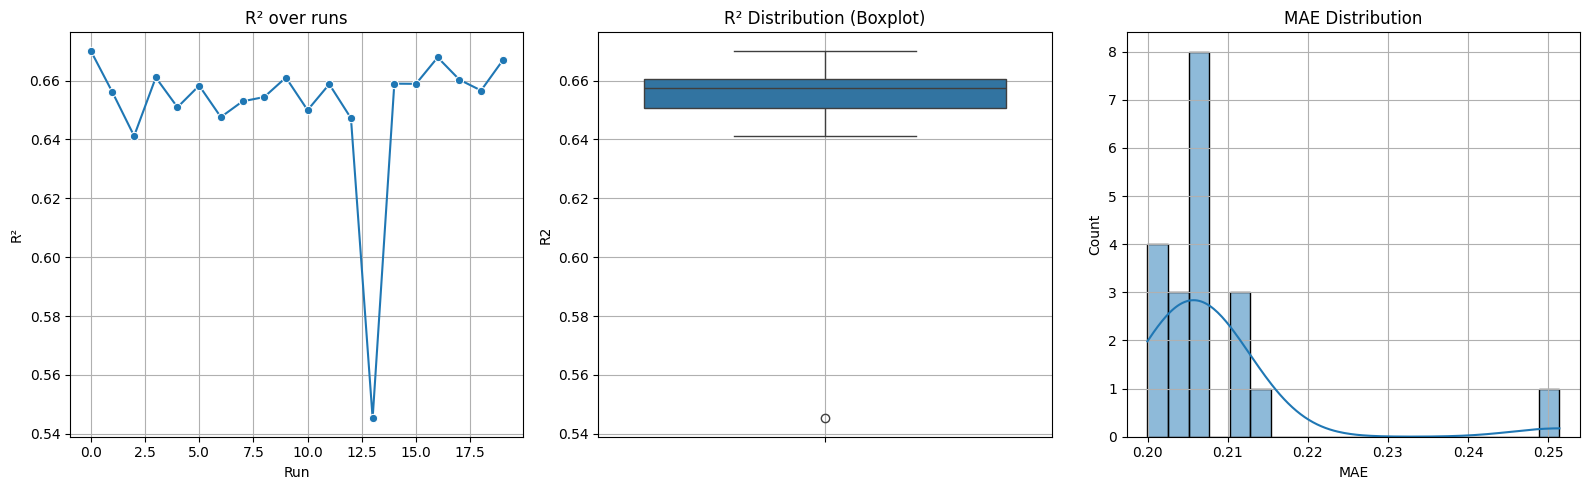

📈 Stability analysis complete:
{
    "R2_mean": 0.6512,
    "R2_std": 0.026,
    "MAE_mean": 0.2083,
    "MAE_std": 0.0107,
    "MSE_mean": 0.086549,
    "MSE_std": 0.006683,
    "runs": 20
}
📁 Saved metrics: /mnt/d/projects/wind_pressure_prediction_2025/final_models/config_001/stability_mlp_64h_7e-03lr_32bs_100ep_Tanh_Adam.json
🖼️  Saved plot: /mnt/d/projects/wind_pressure_prediction_2025/final_models/config_001/stability_plot_mlp_64h_7e-03lr_32bs_100ep_Tanh_Adam.png


In [23]:
# 📁 src/tuning/analyze_stability.py
# ➤ Analyze stability of model performance across multiple seeds
# ➤ Compute mean and std for R², MAE, MSE
# ➤ Generate and save visualizations (line plot, boxplot, histogram)
# ➤ Save stability metrics to JSON for reporting and comparison


# 📥 Load results
df = pd.read_csv(results_csv_path)

# 📊 Compute stability stats
stability = {
    "R2_mean":  round(df["R2"].mean(), 4),
    "R2_std":   round(df["R2"].std(), 4),
    "MAE_mean": round(df["MAE"].mean(), 4),
    "MAE_std":  round(df["MAE"].std(), 4),
    "MSE_mean": round(df["MSE"].mean(), 6),
    "MSE_std":  round(df["MSE"].std(), 6),
    "runs": len(df)
}

# 💾 Save stability metrics
stability_path = os.path.join(SAVE_ROOT, f"stability_{arch_label}.json")
with open(stability_path, "w") as f:
    json.dump(stability, f, indent=4)

# 📈 Visualization
plt.figure(figsize=(16, 5))

# 📌 Plot 1: R² over runs
plt.subplot(1, 3, 1)
sns.lineplot(x="run", y="R2", data=df, marker="o", linewidth=1.5)
plt.title("R² over runs")
plt.xlabel("Run")
plt.ylabel("R²")
plt.grid(True)

# 📌 Plot 2: Boxplot of R²
plt.subplot(1, 3, 2)
sns.boxplot(y="R2", data=df)
plt.title("R² Distribution (Boxplot)")
plt.grid(True)

# 📌 Plot 3: Histogram of MAE
plt.subplot(1, 3, 3)
sns.histplot(df["MAE"], bins=20, kde=True)
plt.title("MAE Distribution")
plt.xlabel("MAE")
plt.grid(True)

# 💾 Save the plot
fig_path = os.path.join(SAVE_ROOT, f"stability_plot_{arch_label}.png")
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

# ✅ Output
print("📈 Stability analysis complete:")
print(json.dumps(stability, indent=4))
print(f"📁 Saved metrics: {stability_path}")
print(f"🖼️  Saved plot: {fig_path}")
